<a href="https://colab.research.google.com/github/mslee2129/coursework-1-mslee2129/blob/master/Copy_of_coursework_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-02-27 19:36:08--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-02-27 19:36:09--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbc73f62b04ac3ffe77390eab3e.dl.dropboxusercontent.com/cd/0/inline/B3QolJ5GK1XYUfbaHyyJcb_iB5Ev_Npg8AEuCmQtpmnaOu5lox6c--DKCRH7kMvDiRvGQoVpcXgAnBvvgfHnWPd8c8WQ2o7vIiEQXTMQbFZTdRvMA-qADGOiKUYVGeaVZ8tWdbLoXqcv8IYJK4lxP3DTM2YwdYB-hIoFehdtXlA9bw/file# [following]
--2023-02-27 19:36:09--  https://ucbc73f62b04ac3ffe77390eab3e.dl.dropboxusercontent.com/cd/0/inline/B3QolJ5GK1XYUfbaHyyJcb_iB5Ev_Npg

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<Figure size 432x288 with 0 Axes>

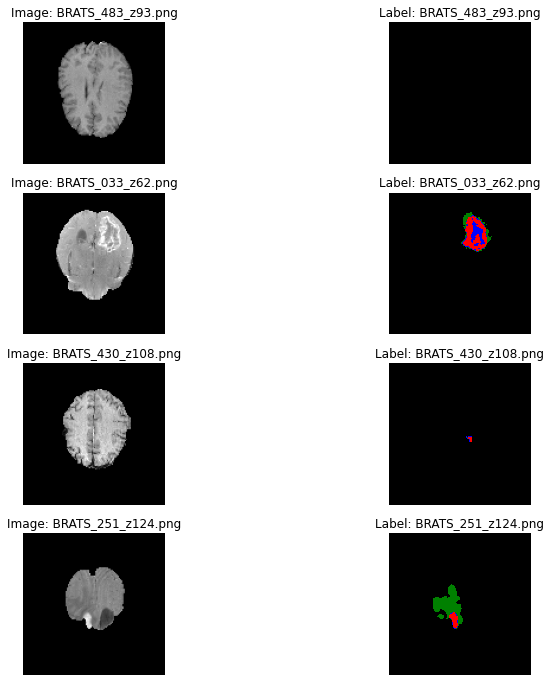

In [103]:
### Insert your code ###
image_dir = 'Task01_BrainTumour_2D/training_images'
label_dir = 'Task01_BrainTumour_2D/training_labels'

images = os.listdir(image_dir)
labels = os.listdir(label_dir)

plt.figure()
f, ax = plt.subplots(4, 2, figsize=(12, 12))

indices = random.sample(range(len(images)), 4)

for i, index in enumerate(indices):
  img_path = os.path.join(image_dir, images[index])
  lbl_path = os.path.join(label_dir, labels[index])
  image = imageio.imread(img_path)
  label = imageio.imread(lbl_path)
  ax[i, 0].imshow(image, cmap = 'gray')
  ax[i, 0].set_title("Image: " + images[index])
  ax[i, 0].axis('off')
  ax[i, 1].imshow(label, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
  ax[i, 1].set_title("Label: " + labels[index])
  ax[i, 1].axis('off')

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []
        indices = random.sample(range(len(self.images)), batch_size)
        ### Insert your code ###
        
        for index in indices:
            # append the image and label to the batch lists
            images.append(self.images[index])
            labels.append(self.labels[index])

        images = np.array(images)
        images = np.expand_dims(images, axis=1)
        labels = np.array(labels)
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [5]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        # Decoder path
        ### Insert your code ###
        
        # n = 128
        self.upconv3 = nn.ConvTranspose2d(n, n//2, kernel_size=2, stride=2, padding=0)
        self.deconv3 = nn.Sequential(
            nn.Conv2d(n, n//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU(),
            nn.Conv2d(n//2, n//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )

        # n = 64
        n //= 2
        self.upconv2 = nn.ConvTranspose2d(n, n//2, kernel_size=2, stride=2, padding=0)
        self.deconv2 = nn.Sequential(
            nn.Conv2d(n, n//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU(),
            nn.Conv2d(n//2, n//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )

        n //= 2
        # n = 32
        self.upconv1 = nn.ConvTranspose2d(n, n//2, kernel_size=2, stride=2, padding=0)
        self.deconv1 = nn.Sequential(
            nn.Conv2d(n, n//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU(),
            nn.Conv2d(n//2, n//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )

        self.deconv = nn.Conv2d(n//2, output_channel, kernel_size=1)
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv3(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.deconv3(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.deconv2(x)

        x = self.upconv1(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.deconv1(x)

        x = self.deconv(x)
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [48]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
train_losses = []
eval_losses = []
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if it % 100 == 0:
      print(f"(Training) Iteration {it}, Loss: {loss.item()}")
      train_losses.append(loss.item())
    ### End of your code ###
    
    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

            logits = model(images)

            loss = criterion(logits, labels)
            print(f"(Evaluation) Iteration {it}, Loss: {loss.item()}")
            eval_losses.append(loss.item())
            ### End of your code ###
    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
(Training) Iteration 100, Loss: 0.6398269534111023
(Evaluation) Iteration 100, Loss: 0.6542260646820068
(Training) Iteration 200, Loss: 0.24727389216423035
(Evaluation) Iteration 200, Loss: 0.24181336164474487
(Training) Iteration 300, Loss: 0.14789564907550812
(Evaluation) Iteration 300, Loss: 0.1528378129005432
(Training) Iteration 400, Loss: 0.09548995643854141
(Evaluation) Iteration 400, Loss: 0.13945181667804718
(Training) Iteration 500, Loss: 0.082743801176548
(Evaluation) Iteration 500, Loss: 0.08768852800130844
(Training) Iteration 600, Loss: 0.05742066726088524
(Evaluation) Iteration 600, Loss: 0.07713595777750015
(Training) Iteration 700, Loss: 0.055856943130493164
(Evaluation) Iteration 700, Loss: 0.07539843022823334
(Training) Iteration 800, Loss: 0.05716588348150253
(Evaluation) Iteration 800, Loss: 0.07264783978462219
(Training) Iteration 900, Loss: 0.05737818405032158
(Evaluation) Iteration 900, Loss: 0.06722930073738098
(Training) Iteration 1000, Loss: 0.05

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

<Figure size 432x288 with 0 Axes>

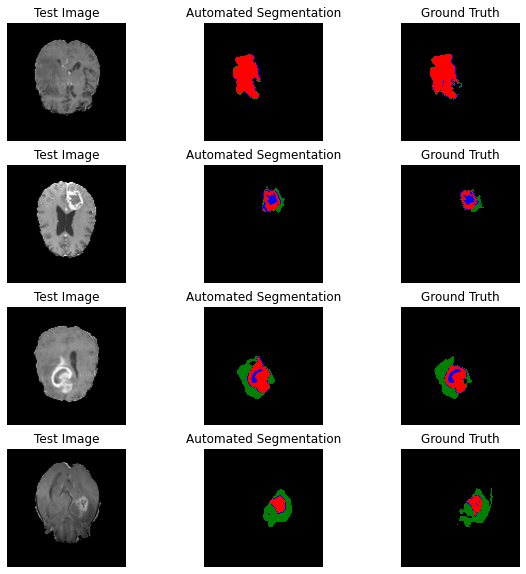

In [127]:
### Insert your code ###
# Load images
num_images = 4
images, labels = test_set.get_random_batch(num_images)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

# Load the saved model from the file system
num_class = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model.load_state_dict(torch.load('saved_models/model_10000.pt'))
model.to(device)
model.eval()

# Apply softmax
with torch.no_grad():
  logits_test = model(images.to(device))
  test_softmax = torch.softmax(logits_test, dim=1)
  _, output = torch.max(test_softmax, dim=1)

# Show figure
plt.figure()
f, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(num_images):
  ax[i, 0].imshow(images[i, 0].cpu(), cmap = 'gray')
  ax[i, 0].set_title("Test Image")
  ax[i, 0].axis('off')
  ax[i, 1].imshow(output[i].cpu(), cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
  ax[i, 1].set_title("Automated Segmentation")
  ax[i, 1].axis('off')
  ax[i, 2].imshow(labels[i].cpu(), cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
  ax[i, 2].set_title("Ground Truth")
  ax[i, 2].axis('off')
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

Accuracy for Image 0: 0.9929861111111111
Precision for Image 0: 0.9854732900762637
Recall for Image 0: 0.9556154783356541

Accuracy for Image 1: 0.9883333333333333
Precision for Image 1: 0.7597257081576498
Recall for Image 1: 0.871631367782871

Accuracy for Image 2: 0.9877083333333333
Precision for Image 2: 0.9119260684580004
Recall for Image 2: 0.9172353652791949

Accuracy for Image 3: 0.9865972222222222
Precision for Image 3: 0.7431215145695353
Recall for Image 3: 0.7112987091910279



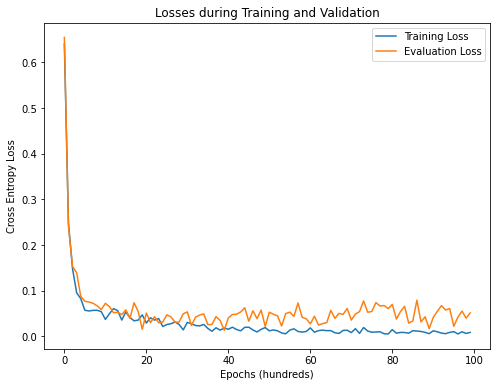

In [128]:
# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Loss Graph
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.title("Losses during Training and Validation")
plt.xlabel("Epochs (hundreds)")
plt.ylabel("Cross Entropy Loss")
plt.legend()

# Evaluation Metrics
for i in range(num_class):
  labels_1d = np.ravel(labels[i].cpu())
  output_1d = np.ravel(output[i].cpu())
  accuracy = accuracy_score(labels_1d, output_1d)
  precision = precision_score(labels_1d, output_1d, average='macro', zero_division=1)
  recall = recall_score(labels_1d, output_1d, average='macro')
  print(f"Accuracy for Image {i}: {accuracy}")
  print(f"Precision for Image {i}: {precision}")
  print(f"Recall for Image {i}: {recall}")
  print()



In [ ]:
'''
My trained model has a loss of 0.009 on the training set and 0.052 on the 
validation set after 10000 epochs. This signifies that the model is able to fit 
the training data well and is able to capture the features of the input data.
The evaluation metrics such as accuracy, precision, and recall of the model are
also ways to evaluate the model. In this case, the model generally has very
high accuracy, but the precision and recall seem to fluctuate. With this in
mind, the model can be improved in several ways.

Architecture:
- Depth: One way to do this is by increasing the depth of the UNet architecture. 
Increasing the number of Down- and -upsampling layers would allow the model to 
capture more complex features, altouugh this may lead to overfitting. 
- Skip connections: Skip connections help the network to retain some features from
earlier layers, preventing those features from being lost.
- Activation function: Perhaps using another activation function such as a 
LeakyReLU may improve the performance of the model as it mitigates some of the 
problems a ReLU might have, such as the 'dying ReLU' problem.

Training:
- Batch size: When training the model, the batch size can be increased to
potentially improve its performance.
- Loss function: Changing the loss function may also improve the model, such as
using Dice loss instead of Cross Entropy Loss.
'''